In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as de
import dedalus.extras.plot_tools as plot_tools
import atmospheres as atmos
import tides
import modes
import parameters as param
import mpi4py.MPI as MPI
import uuid
import logging
logger = logging.getLogger(__name__)

In [5]:
%matplotlib notebook

In [6]:
import importlib
importlib.reload(param)

<module 'parameters' from '/Users/kburns/Dropbox/Projects/pg_coupling/hg/compressible/notebooks/parameters.py'>

## Solve 1D linear tide

In [7]:
# Solve tide
domain, problem = tides.linear_tide_1d(param)
solver = problem.build_solver()
solver.solve()

2018-11-06 16:49:26,498 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2018-11-06 16:49:26,862 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.8e+01/s
2018-11-06 16:49:26,866 atmospheres 0/1 INFO :: Perturbation norm: 2.9694526932498194e-07
2018-11-06 16:49:27,116 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2018-11-06 16:49:27,119 atmospheres 0/1 INFO :: Perturbation norm: 1.7485936178989882e-14
2018-11-06 16:49:27,798 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s


<IPython.core.display.Javascript object>


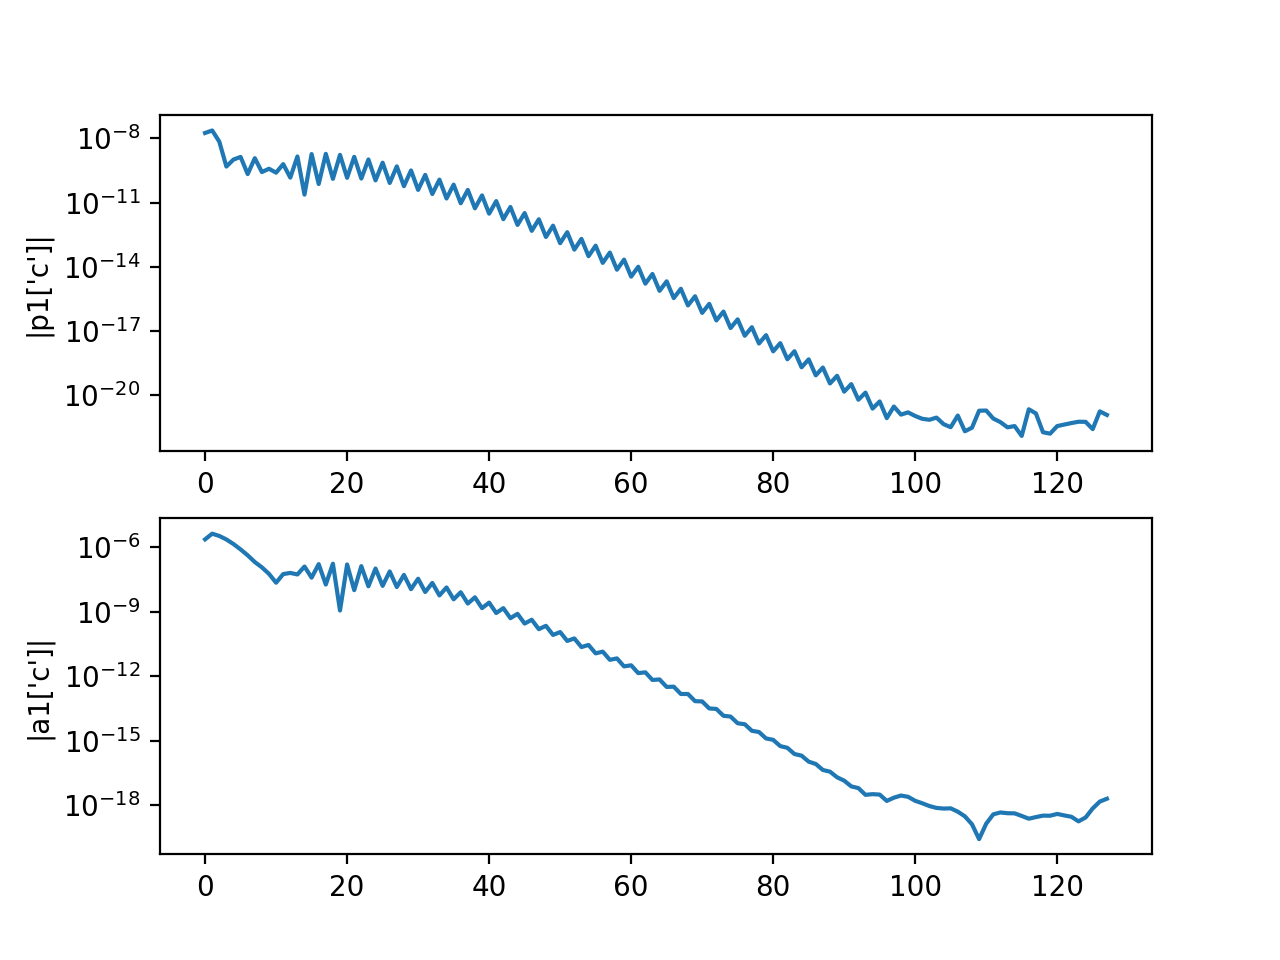

Text(0,0.5,"|a1['c']|")

In [8]:
# Plot coefficients to check convergence
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.semilogy(np.abs(solver.state['p1']['c']))
ax2.semilogy(np.abs(solver.state['a1']['c']))
ax1.set_ylabel("|p1['c']|")
ax2.set_ylabel("|a1['c']|")

<IPython.core.display.Javascript object>


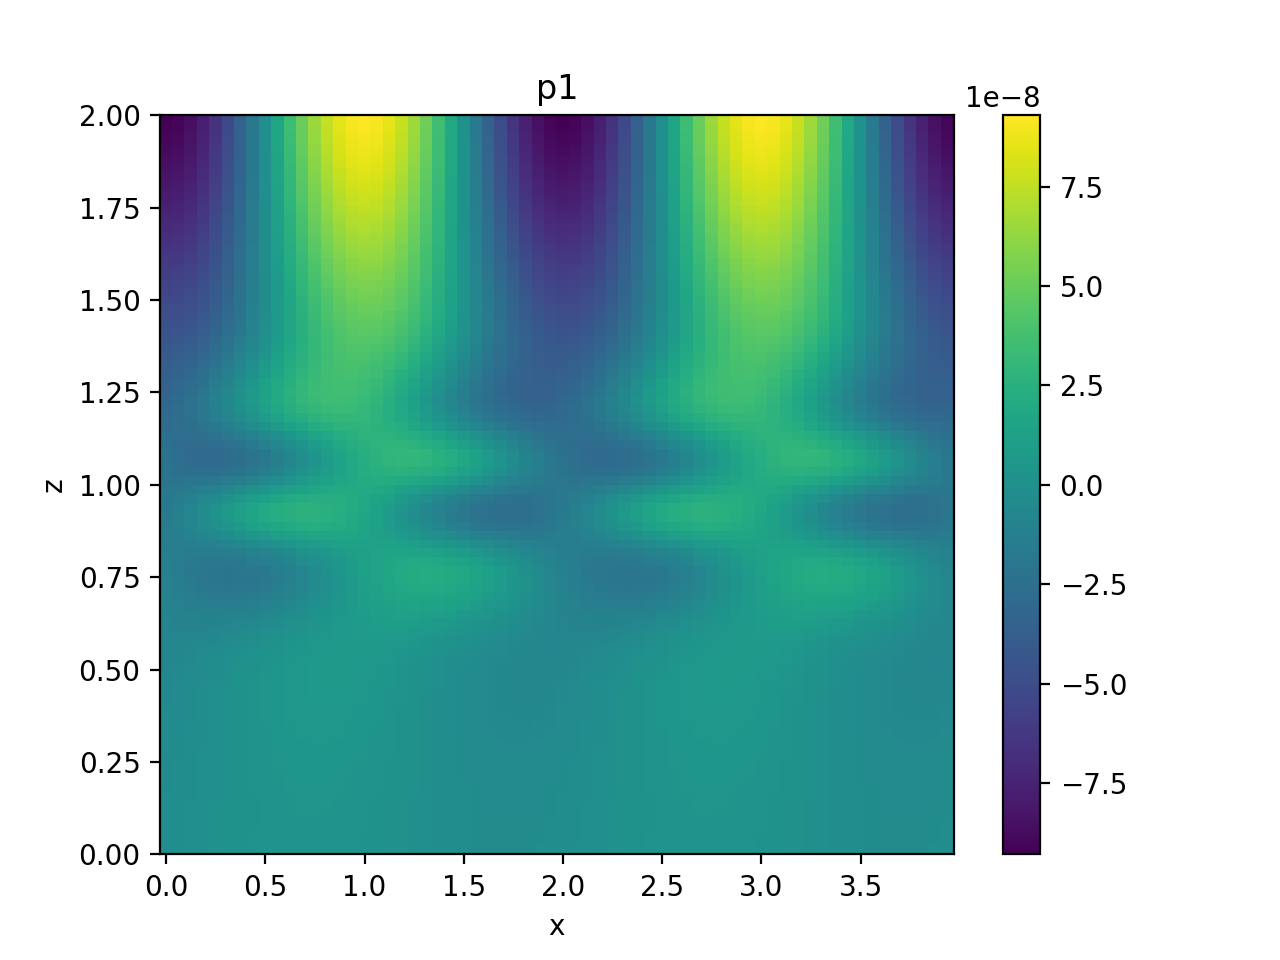

Text(0,0.5,'z')

In [9]:
# Plot tide
scales = 1
kx = param.k_tide
x = np.linspace(0, param.Lx, param.Nx, endpoint=False)[:,None]
z = domain.grid(0, scales=scales)
Z, X = plot_tools.quad_mesh(z.flatten(), x.flatten())

field = 'p1'
f = solver.state[field]
f.set_scales(scales)
fig, axes = plt.subplots(1, 1)
im = axes.pcolormesh(X, Z, 2*np.real(np.exp(1j*kx*x)*f['g']))
plt.colorbar(im)
axes.set_title(field)
axes.set_xlabel('x')
axes.set_ylabel('z')

## Mode amplitude extraction

Eigenmodes:

$$\lambda_i M \cdot X_i + L \cdot X_i = 0$$

Adjoint modes:

$$Y_j \cdot M \cdot X_i = \delta_{ji}$$

Decompose arbitrary state:

$$X = \sum_i a_i X_i$$

$$a_j = Y_j \cdot M \cdot X$$

Decompose linear solution:

$$L \cdot X = F$$

$$\sum_i a_i L \cdot X_i = F$$

$$\sum_i a_i \lambda_i M \cdot X_i = - F$$

$$a_j = - \frac{Y_j \cdot F}{\lambda_j}$$

In [10]:
# Check mode amplitudes from projecting RHS vs extracting solved coefficients
evals, evecs, adj_evals, adj_evecs, proj, sevp, pevp = modes.compute_eigenmodes(param, param.k_tide, sparse=True, N=20, target=20)

2018-11-06 16:49:54,107 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2018-11-06 16:49:54,475 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.8e+01/s
2018-11-06 16:49:54,480 atmospheres 0/1 INFO :: Perturbation norm: 2.9694526932498194e-07
2018-11-06 16:49:54,729 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2018-11-06 16:49:54,732 atmospheres 0/1 INFO :: Perturbation norm: 1.7485936178989882e-14
2018-11-06 16:49:54,735 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2018-11-06 16:49:55,604 modes 0/1 INFO :: Max eval mismatch: 7.872606e-13


In [11]:
# Construct RHS
p = solver.pencils[0]
pFe = solver.Fe.get_pencil(p)
pFb = solver.Fb.get_pencil(p)
b = p.G_eq * pFe + p.G_bc * pFb
X = solver.state.get_pencil(p).copy()
print('Check L.X = b:', np.allclose(p.L@X, b))

# Bias evals by tidal frequency, which is left out of EVP
lam = evals - (-1j*param.ω_tide)
amps_proj = - adj_evecs.T.conj() @ b / lam
amps_solve = proj @ X
print('A_proj == A_solve:', np.allclose(amps_proj/param.A_tide, amps_solve/param.A_tide))

Check L.X = b: True
A_proj == A_solve: True


## Mode orthogonality

In [12]:
# Check orthogonality of modes
evals, evecs, adj_evals, adj_evecs, proj, sevp, pevp = modes.compute_eigenmodes(param, param.k_tide, sparse=False)

2018-11-06 16:49:59,040 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2018-11-06 16:49:59,409 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.8e+01/s
2018-11-06 16:49:59,413 atmospheres 0/1 INFO :: Perturbation norm: 2.9694526932498194e-07
2018-11-06 16:49:59,665 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2018-11-06 16:49:59,668 atmospheres 0/1 INFO :: Perturbation norm: 1.7485936178989882e-14
2018-11-06 16:49:59,671 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2018-11-06 16:50:03,863 modes 0/1 INFO :: Max eval mismatch: 0.000000e+00


<IPython.core.display.Javascript object>


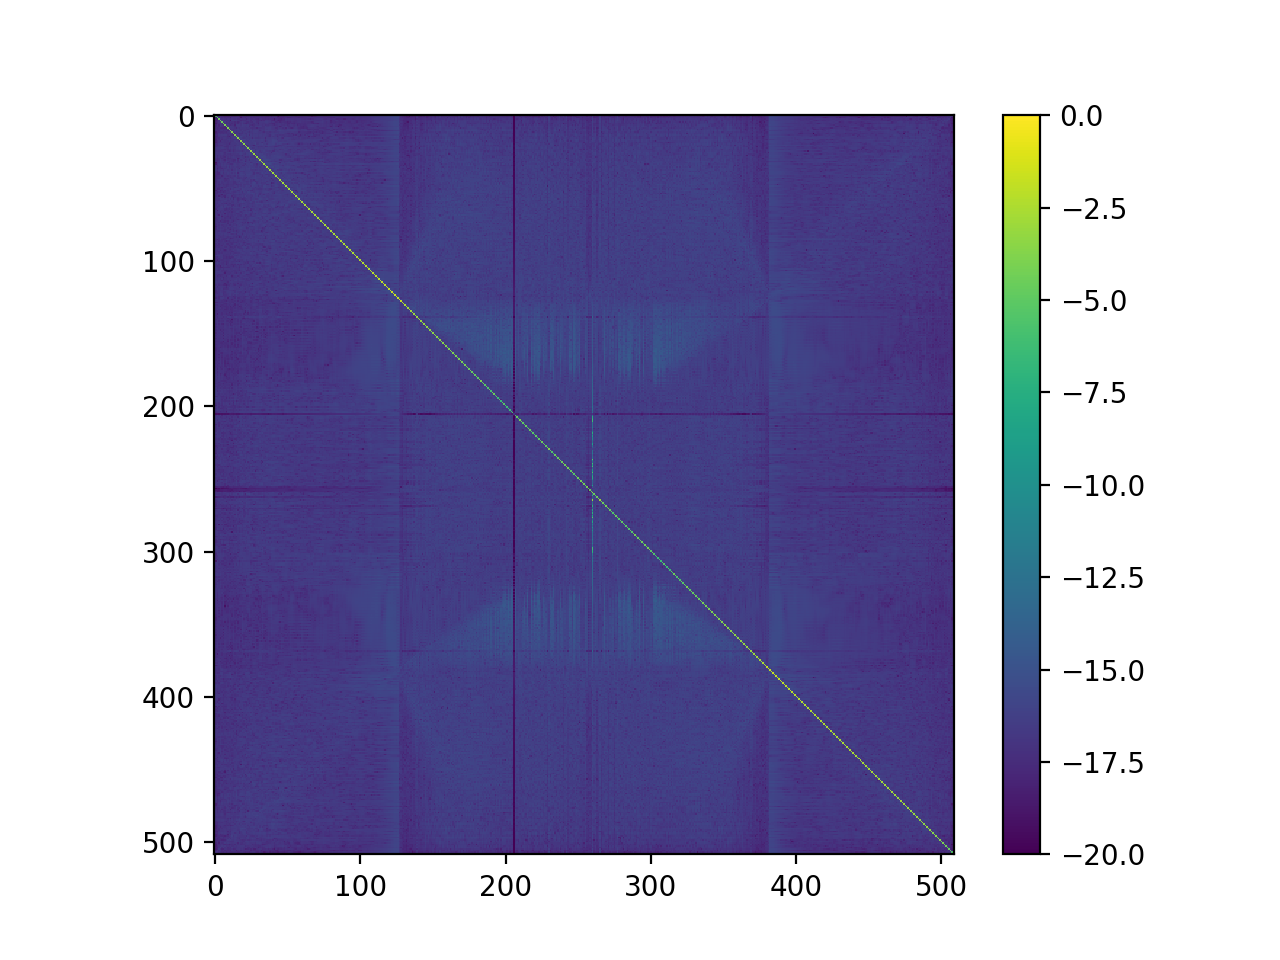

<IPython.core.display.Javascript object>


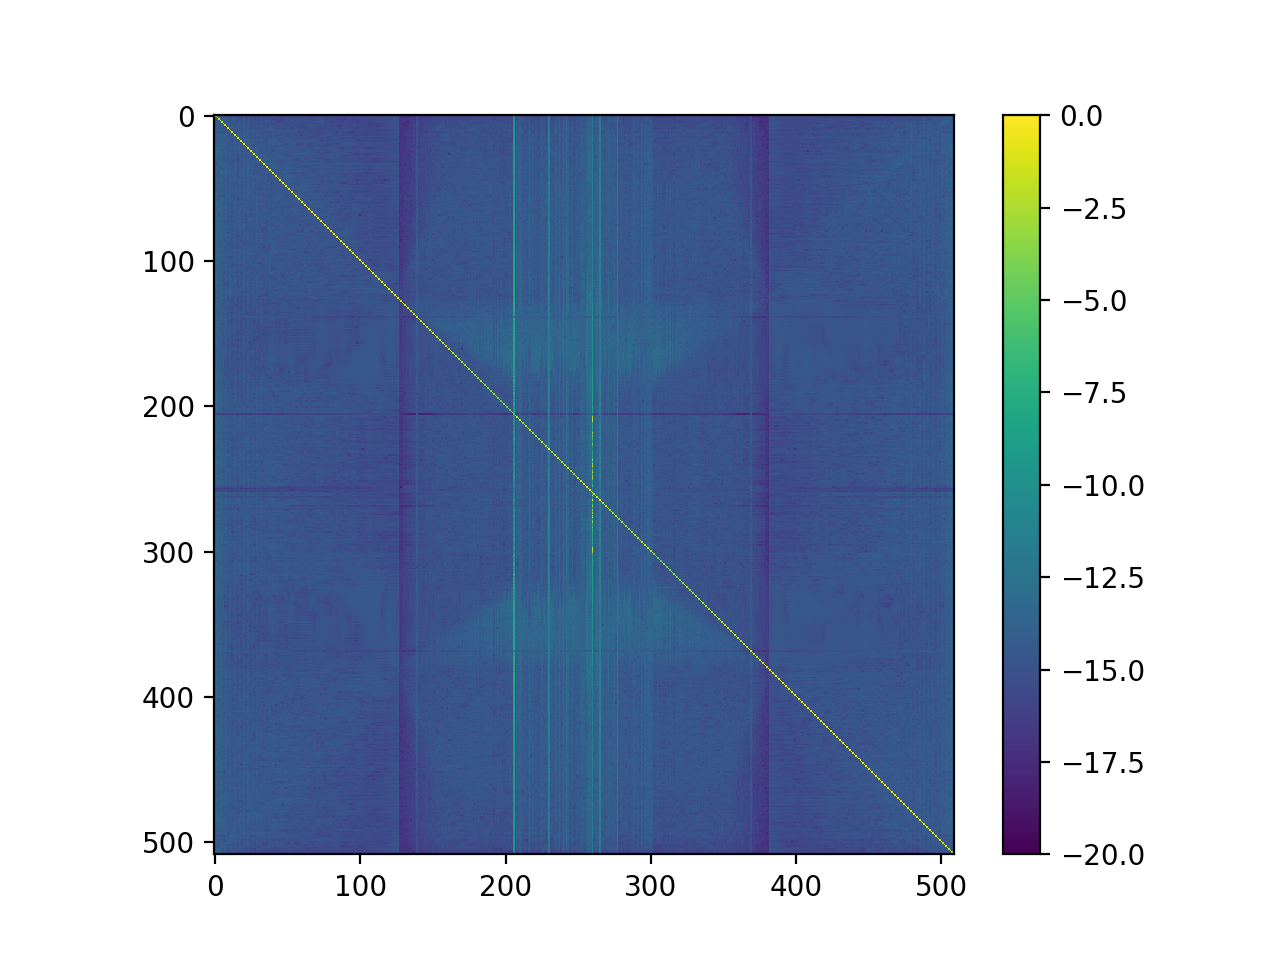

<IPython.core.display.Javascript object>


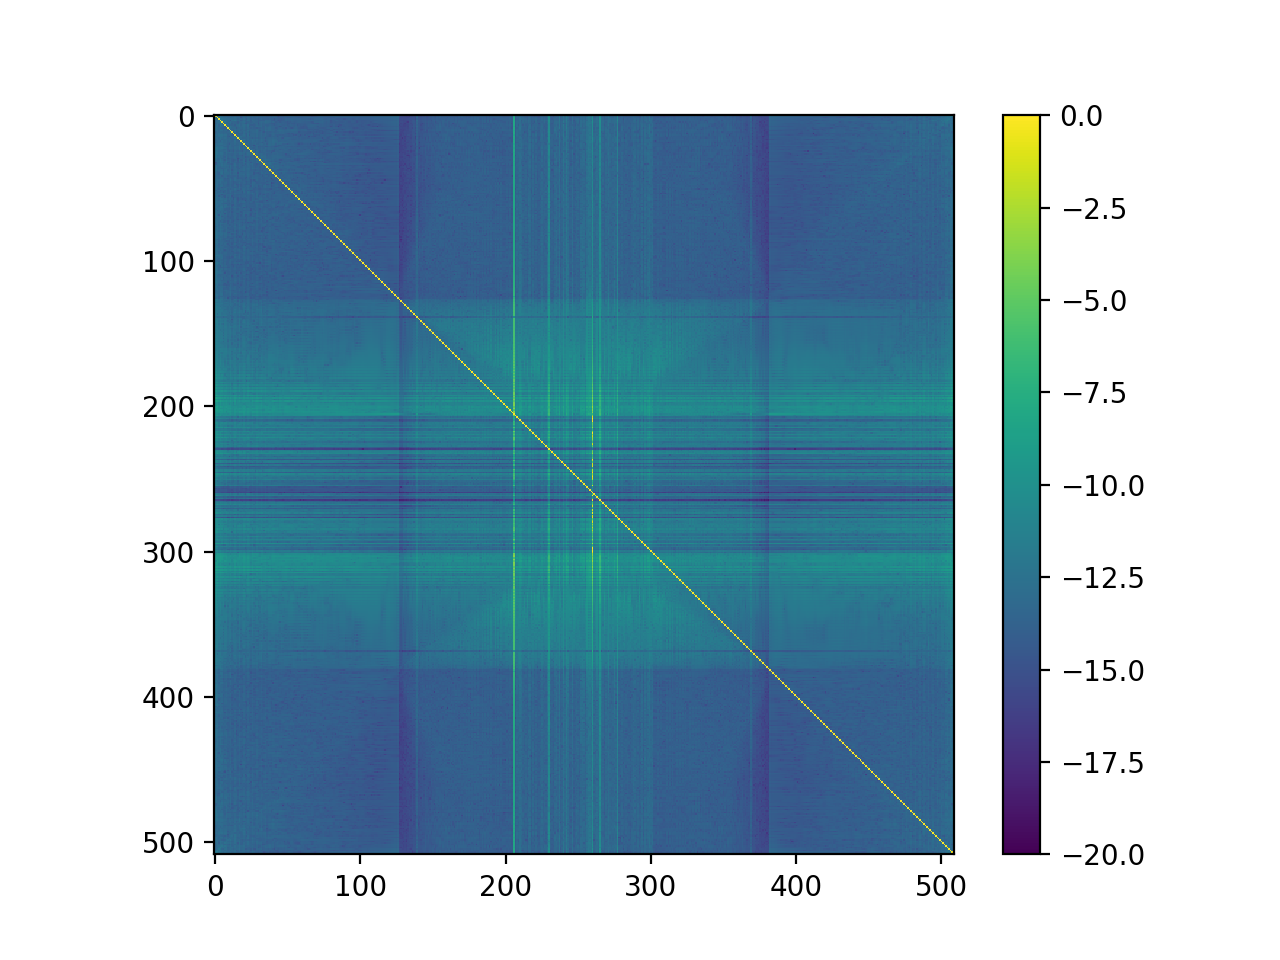

/Users/kburns/Software/miniconda3/envs/dedalus-mkl/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply


<IPython.core.display.Javascript object>


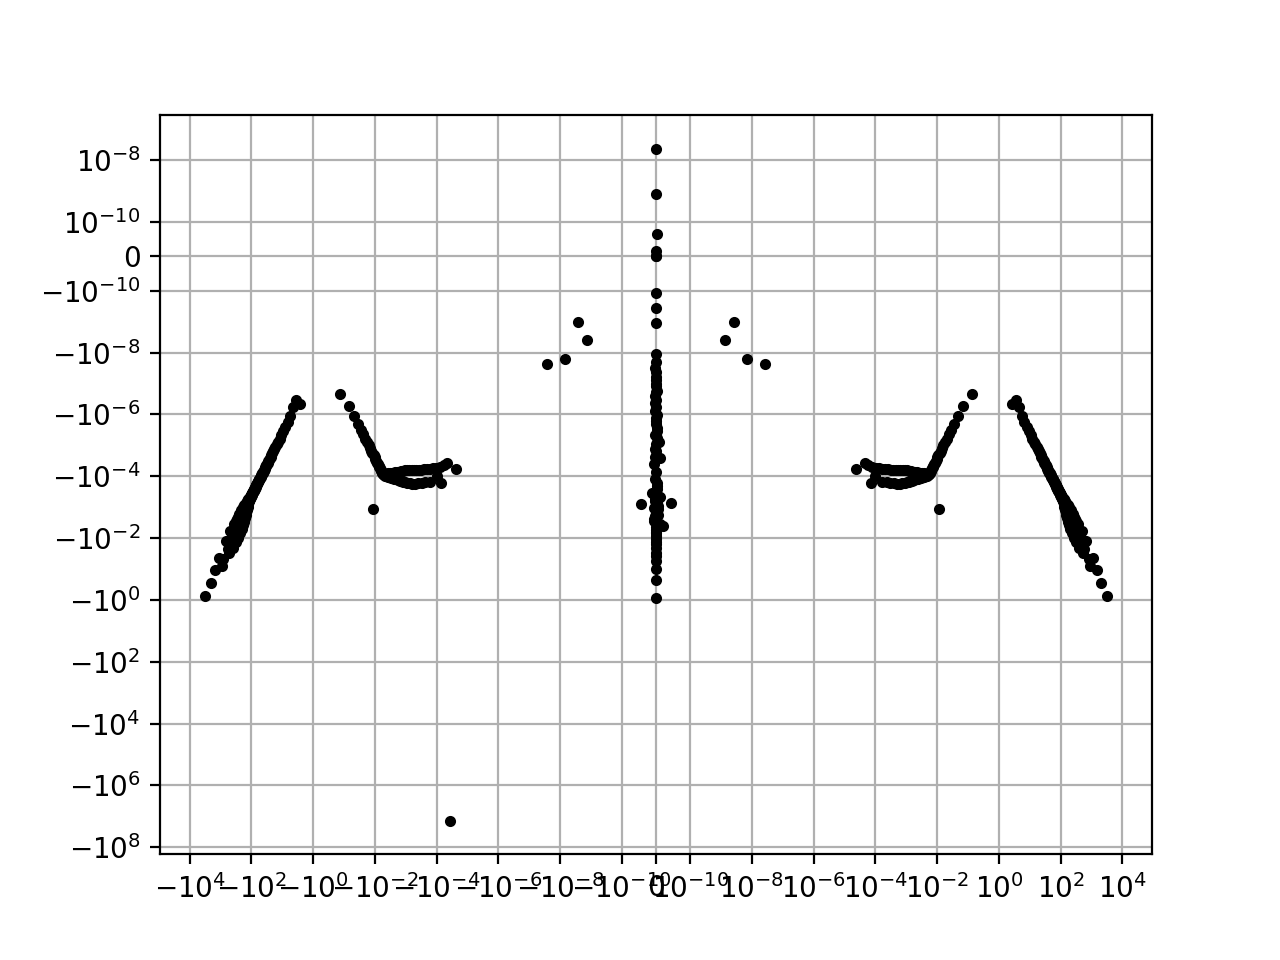

In [13]:
# Redo manipulations on eigenmodes, examining metric along the way
sevp.eigenvalues = sevp.full_eigenvalues
sevp.eigenvectors = sevp.full_eigenvectors
sevp.adjoint_eigenvalues = sevp.full_adjoint_eigenvalues
sevp.adjoint_eigenvectors = sevp.full_adjoint_eigenvectors
pencil = sevp.pencils[0]

# Filter modes
minabs = 0
maxabs = np.inf
keep = (np.isfinite(sevp.eigenvalues) * 
        (minabs < np.abs(sevp.eigenvalues)) * 
        (np.abs(sevp.eigenvalues) < maxabs))
sevp.eigenvalues = sevp.eigenvalues[keep]
sevp.eigenvectors = sevp.eigenvectors[:,keep]
sevp.adjoint_eigenvalues = sevp.adjoint_eigenvalues[keep]
sevp.adjoint_eigenvectors = sevp.adjoint_eigenvectors[:,keep]
# Sort modes
sorting = np.argsort(1j*sevp.eigenvalues)
sevp.eigenvalues = sevp.eigenvalues[sorting]
sevp.eigenvectors = sevp.eigenvectors[:,sorting]
sorting = np.argsort(1j*sevp.adjoint_eigenvalues.conj())
sevp.adjoint_eigenvalues = sevp.adjoint_eigenvalues[sorting]
sevp.adjoint_eigenvectors = sevp.adjoint_eigenvectors[:,sorting]
metric_1 = sevp.adjoint_eigenvectors.T.conj() @ pencil.M @ sevp.eigenvectors
# Normalize by energy
metric_diag = modes.compute_energies(sevp)
sevp.eigenvectors /= np.sqrt(metric_diag)
metric_2 = sevp.adjoint_eigenvectors.T.conj() @ pencil.M @ sevp.eigenvectors
# Normalize adjoint modes
metric = sevp.adjoint_eigenvectors.T.conj() @ pencil.M @ sevp.eigenvectors
sevp.adjoint_eigenvectors /= np.diag(metric).conj()
metric_3 = sevp.adjoint_eigenvectors.T.conj() @ pencil.M @ sevp.eigenvectors

plt.figure()
plt.imshow(np.log10(np.abs(metric_1)), cmap='viridis', clim=(-20,0))
plt.colorbar()

plt.figure()
plt.imshow(np.log10(np.abs(metric_2)), cmap='viridis', clim=(-20,0))
plt.colorbar()

plt.figure()
plt.imshow(np.log10(np.abs(metric_3)), cmap='viridis', clim=(-20,0))
plt.colorbar()

freqs = 1j * sevp.full_eigenvalues
plt.figure()
plt.plot(freqs[keep].real, freqs[keep].imag, '.k')
plt.plot(freqs[~keep].real, freqs[~keep].imag, '.r')
plt.xscale('symlog', linthreshx=1e-10)
plt.yscale('symlog', linthreshy=1e-10)
plt.grid()

<IPython.core.display.Javascript object>


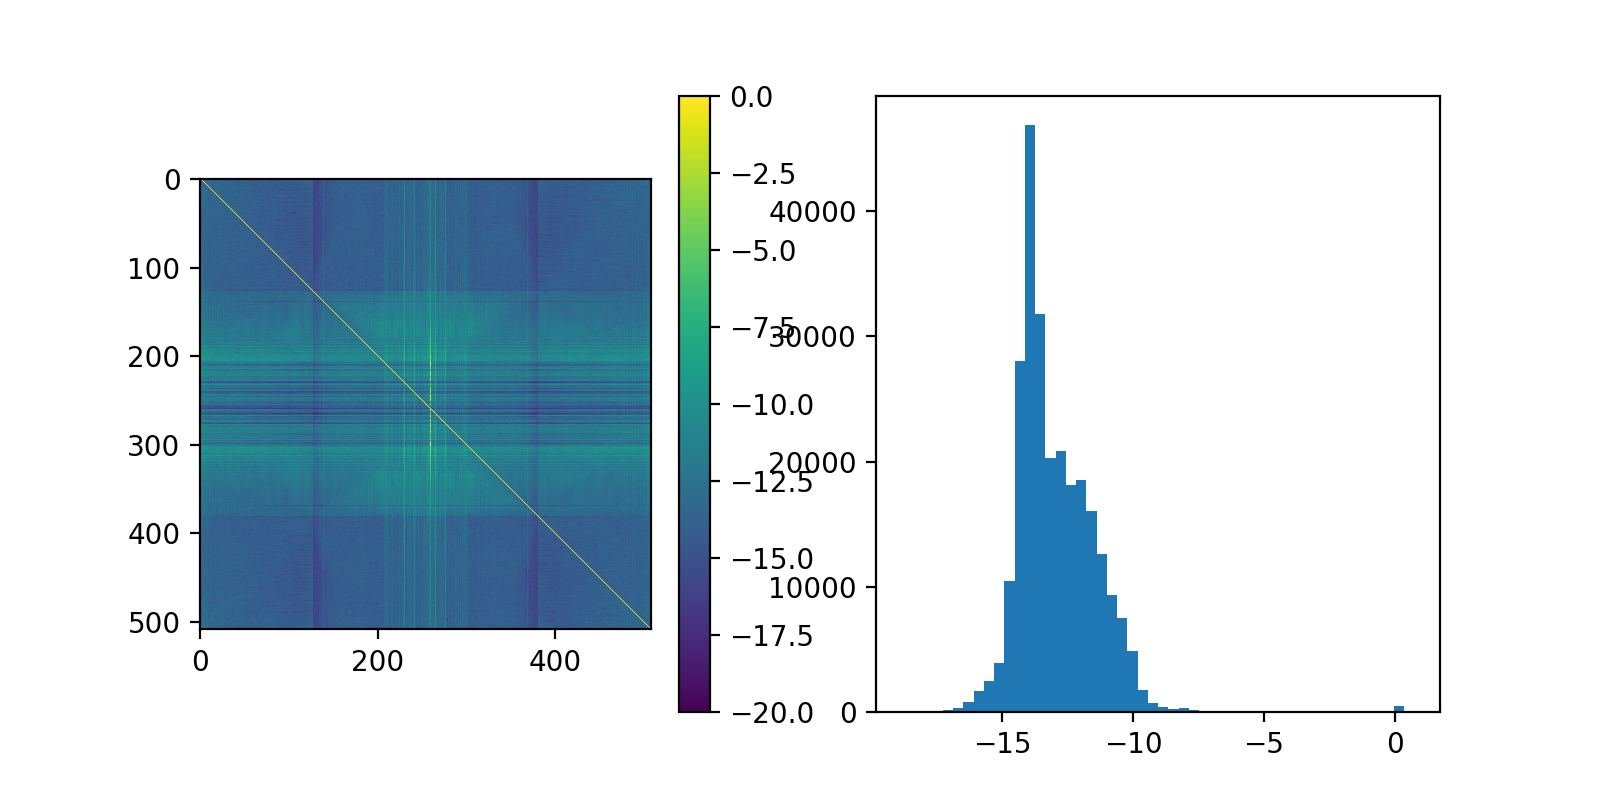

<IPython.core.display.Javascript object>


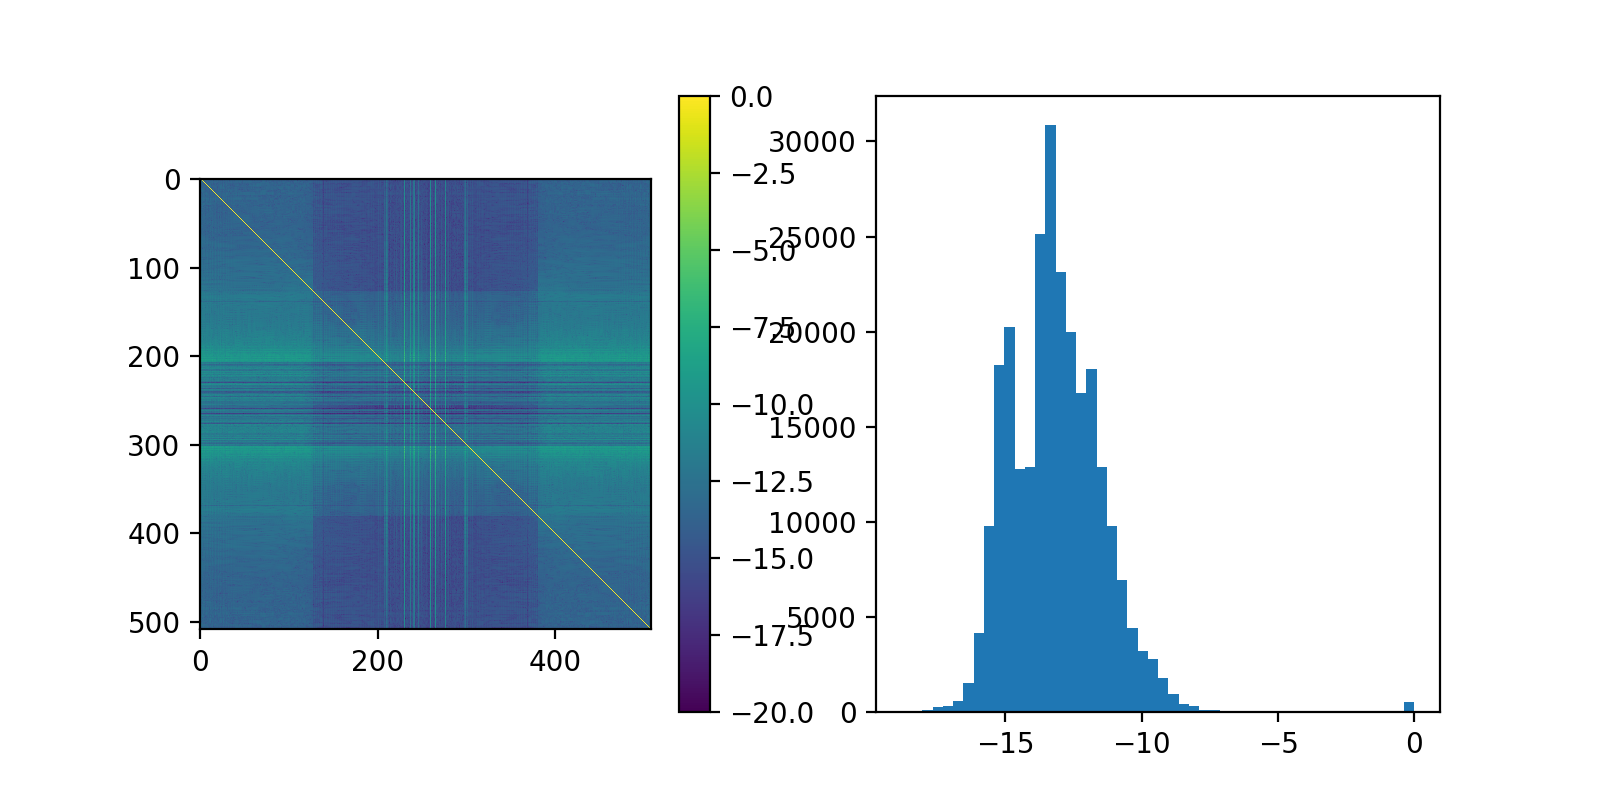

<IPython.core.display.Javascript object>


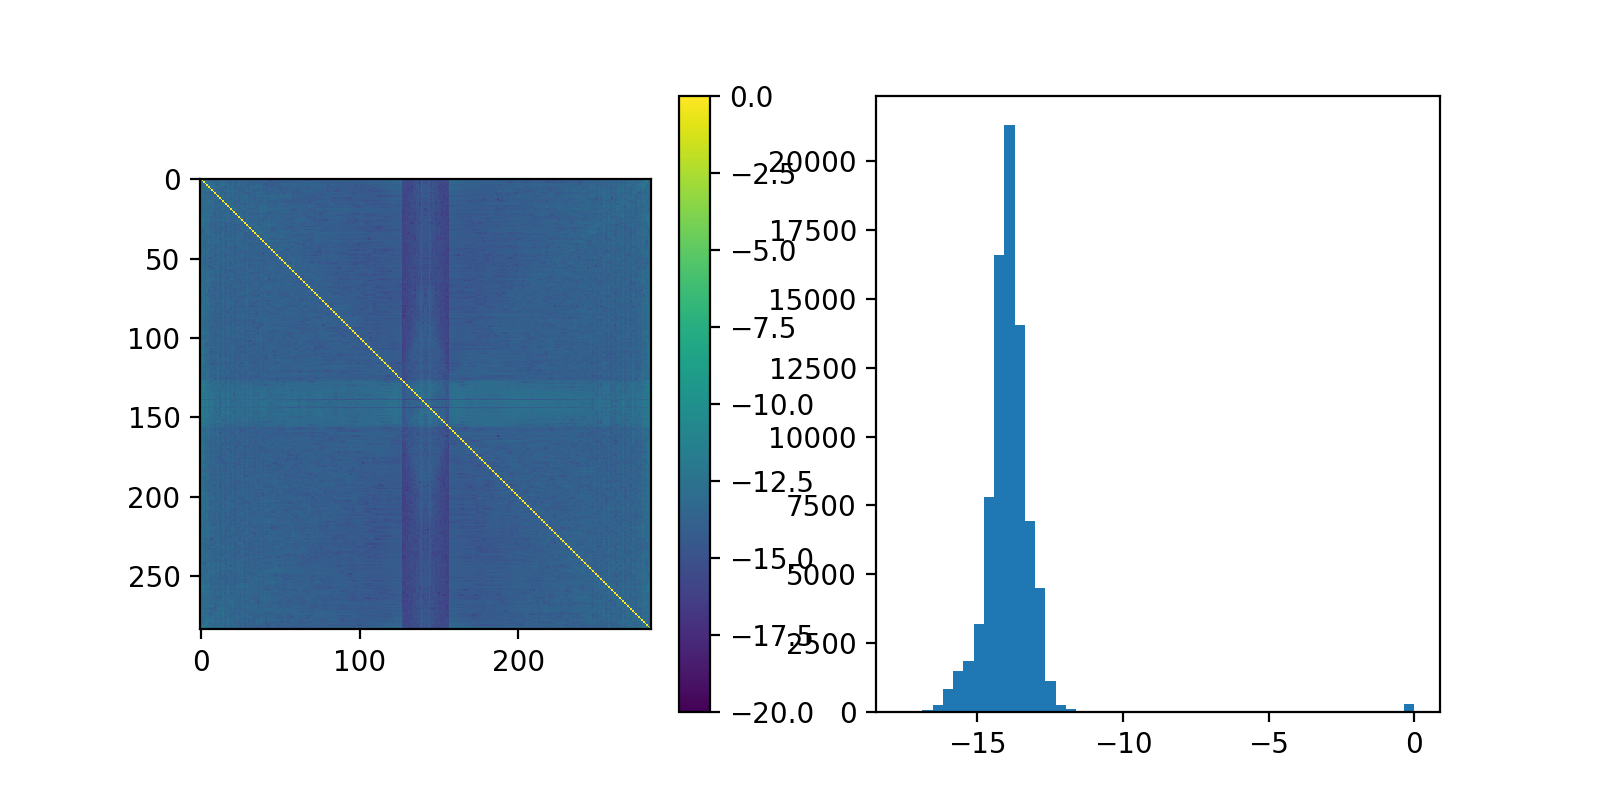

<IPython.core.display.Javascript object>


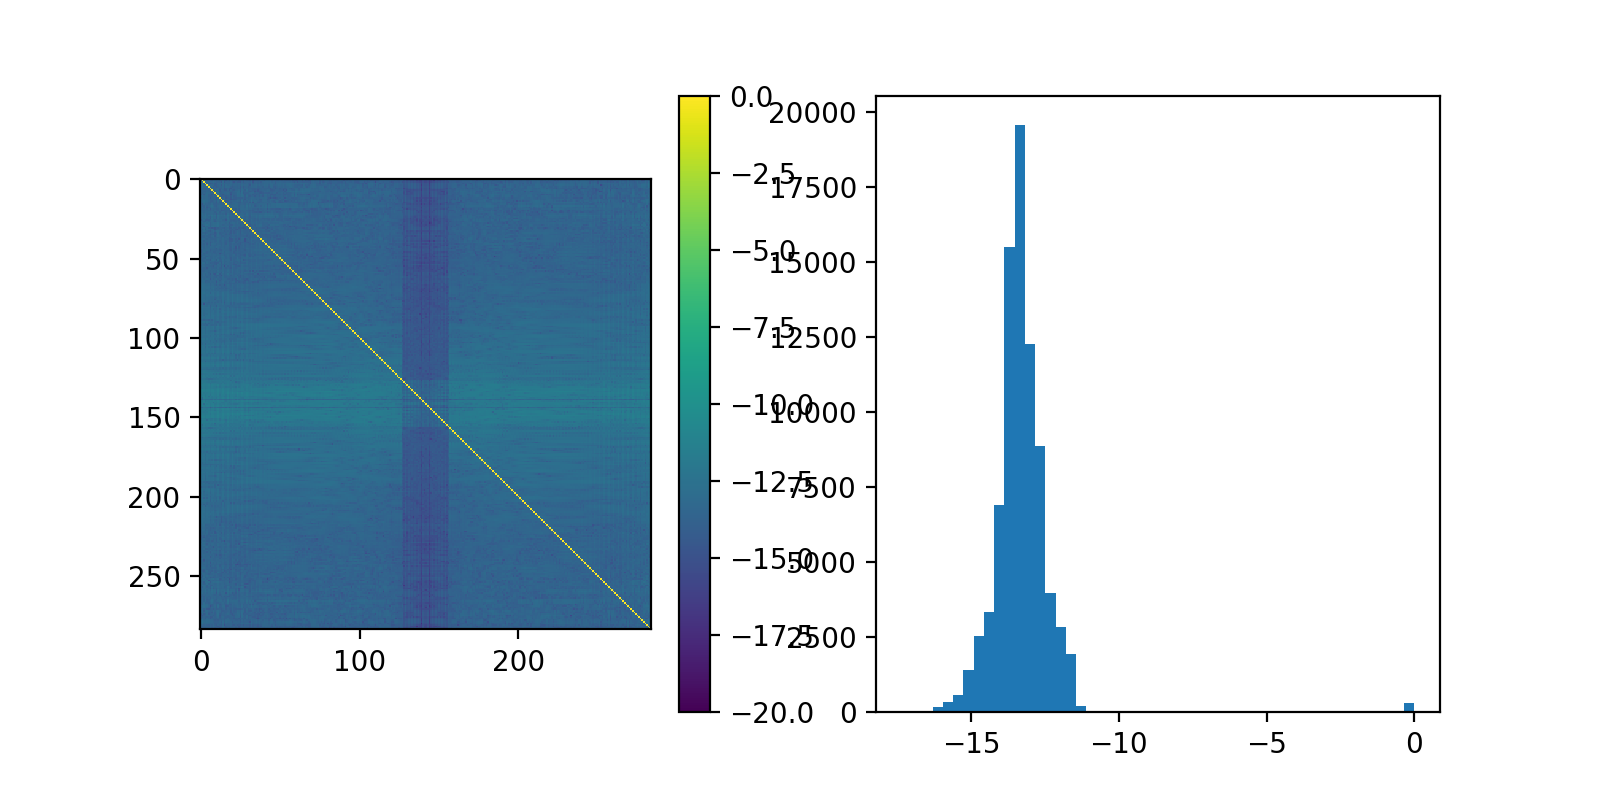

(array([3.0000e+00, 9.0000e+00, 4.4000e+01, 1.5200e+02, 3.2000e+02,
        5.7200e+02, 1.3900e+03, 2.5390e+03, 3.3230e+03, 6.9000e+03,
        1.5521e+04, 1.9562e+04, 1.2262e+04, 8.8670e+03, 3.9550e+03,
        2.8190e+03, 1.9340e+03, 2.0000e+02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8400e+02]),
 array([-1.73307563e+01, -1.69841412e+01, -1.66375261e+01, -1.62909110e+01,
        -1.59442958e+01, -1.55976807e+01, -1.52510656e+01, -1.49044505e+01,
        -1.45578353e+01, -1.42112202e+01, -1.38646051e+01, -1.35179900e+01,
        -1.31713748e+01, -1.28247597e+01, -1.24781446e+01, -1.21315294e+01,
        -1.178

In [14]:
# Attempt to update pseudoinverse to improve orthogonality
A = sevp.eigenvectors
X = sevp.adjoint_eigenvectors.T.conj() @ pencil.M
metric_1 = X @ A

def newton_update(A, X, loops=1):
    N, M = A.shape
    IN = np.identity(N)
    for i in range(loops):
        X = X @ (2*IN - A@X)
    return X

X = newton_update(A, X, loops=10)
metric_2 = X @ A

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
im = ax1.imshow(np.log10(np.abs(metric_1)), cmap='viridis', clim=(-20,0))
fig.colorbar(im, ax=ax1)
ax2.hist(np.log10(np.abs(metric_1.flatten())), bins=50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
im = ax1.imshow(np.log10(np.abs(metric_2)), cmap='viridis', clim=(-20,0))
fig.colorbar(im, ax=ax1)
ax2.hist(np.log10(np.abs(metric_2.flatten())), bins=50)

filt = np.abs(sevp.eigenvalues.imag) > 1e-2

metric_1_filt = metric_1[filt,:][:,filt]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
im = ax1.imshow(np.log10(np.abs(metric_1_filt)), cmap='viridis', clim=(-20,0))
fig.colorbar(im, ax=ax1)
ax2.hist(np.log10(np.abs(metric_1_filt.flatten())), bins=50)

metric_2_filt = metric_2[filt,:][:,filt]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
im = ax1.imshow(np.log10(np.abs(metric_2_filt)), cmap='viridis', clim=(-20,0))
fig.colorbar(im, ax=ax1)
ax2.hist(np.log10(np.abs(metric_2_filt.flatten())), bins=50)

## Mode completeness

In [15]:
# Check completeness of modes for representing linear tide
evals, evecs, adj_evals, adj_evecs, proj, sevp, pevp = modes.compute_eigenmodes(param, param.k_tide, sparse=False)

2018-11-06 16:51:00,751 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2018-11-06 16:51:01,121 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+01/s
2018-11-06 16:51:01,125 atmospheres 0/1 INFO :: Perturbation norm: 2.9694526932498194e-07
2018-11-06 16:51:01,375 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2018-11-06 16:51:01,378 atmospheres 0/1 INFO :: Perturbation norm: 1.7485936178989882e-14
2018-11-06 16:51:01,381 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2018-11-06 16:51:05,548 modes 0/1 INFO :: Max eval mismatch: 0.000000e+00


Check L.X = b: True
X == X_recon: True
|X - X_recon|/|X|: 3.040811524925148e-06


<IPython.core.display.Javascript object>


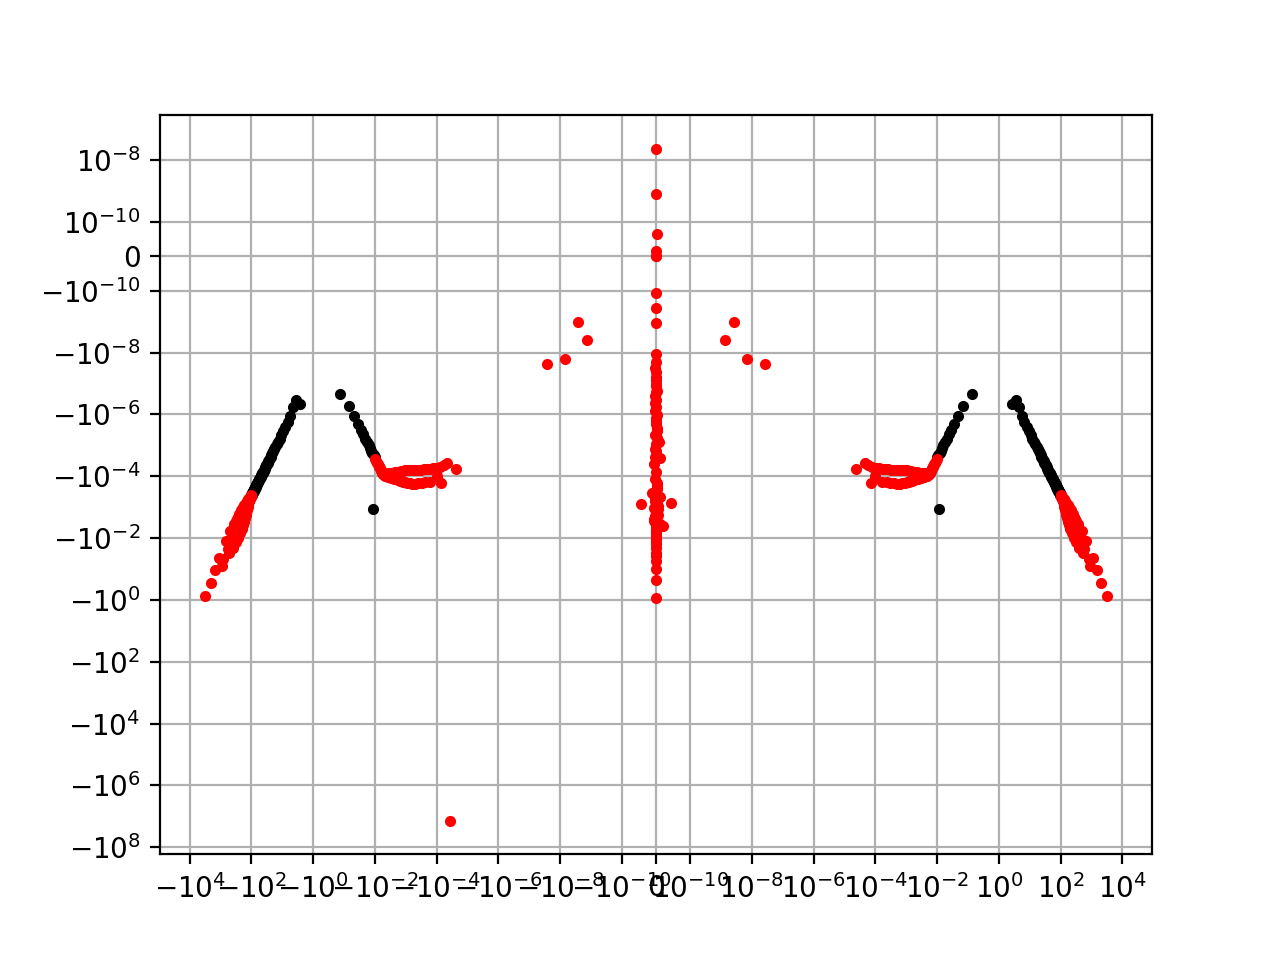

<IPython.core.display.Javascript object>


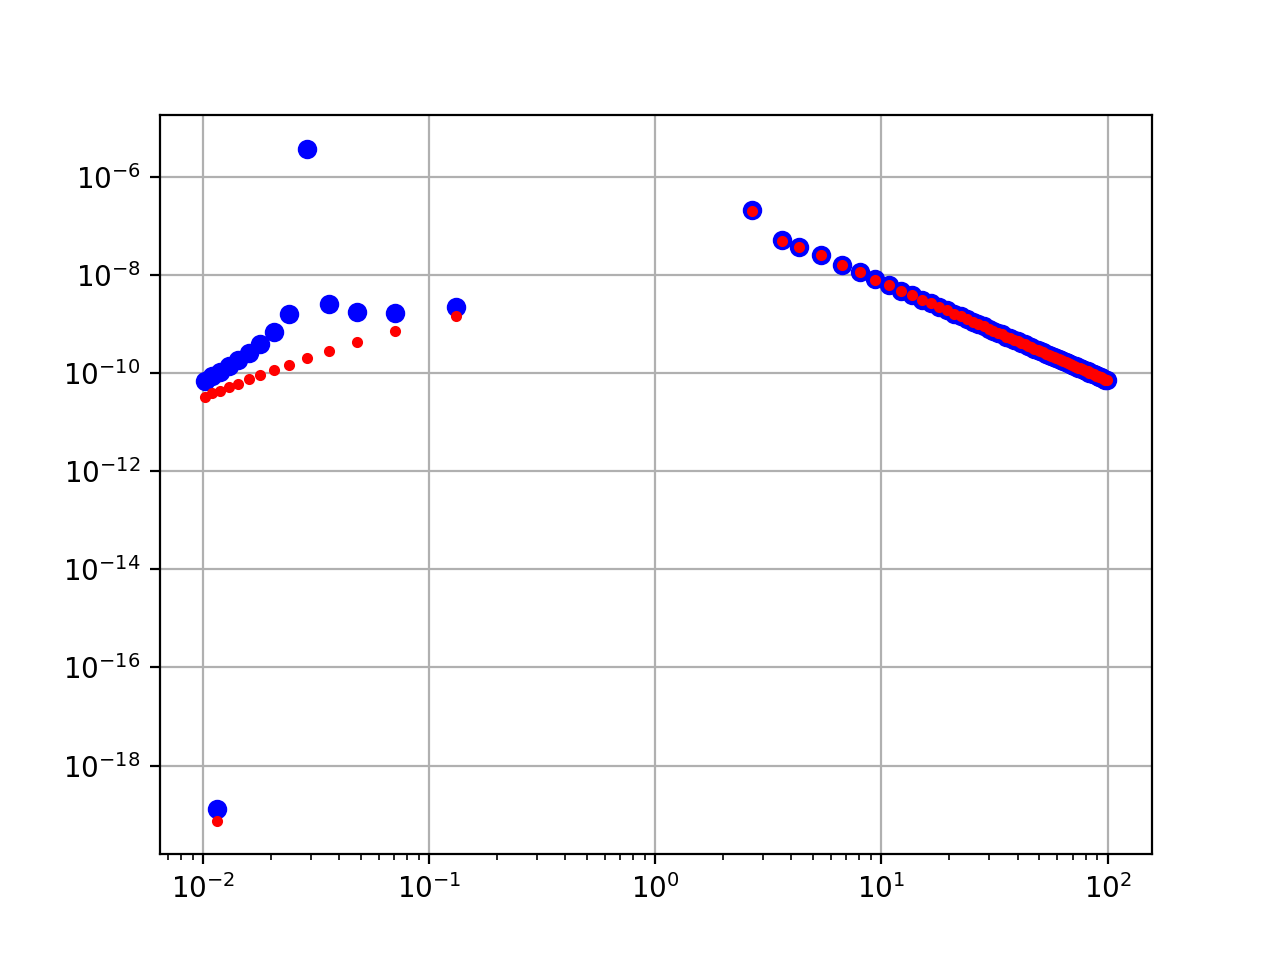

In [16]:
# Construct RHS
p = solver.pencils[0]
pFe = solver.Fe.get_pencil(p)
pFb = solver.Fb.get_pencil(p)
b = p.G_eq * pFe + p.G_bc * pFb
X = solver.state.get_pencil(p).copy()
print('Check L.X = b:', np.allclose(p.L@X, b))

# Bias evals by tidal frequency, which is left out of EVP
freqs = 1j * evals
filt = (np.abs(freqs.real) > 1e-2) * (np.abs(freqs.real) < 1e2)
lam = evals - (-1j*param.ω_tide)
amps_proj = - adj_evecs[:,filt].T.conj() @ b / lam[filt]
X_recon = evecs[:,filt] @ amps_proj
dX = X - X_recon

print('X == X_recon:', np.allclose(X, X_recon))
print('|X - X_recon|/|X|:', (np.dot(dX, dX.conj()) / np.dot(X, X.conj())).real)

plt.figure()
plt.plot(freqs[filt].real, freqs[filt].imag, '.k')
plt.plot(freqs[~filt].real, freqs[~filt].imag, '.r')
plt.xscale('symlog', linthreshx=1e-10)
plt.yscale('symlog', linthreshy=1e-10)
plt.grid()

freq = 1j * evals
plt.figure()
plt.loglog(freqs[filt].real, np.abs(amps_proj), 'ob')
plt.loglog(-freqs[filt].real, np.abs(amps_proj), '.r')
plt.grid()

Check L.X = b: True
X == X_recon: True
|X - X_recon|/|X|: 3.006990351071366e-05


<IPython.core.display.Javascript object>


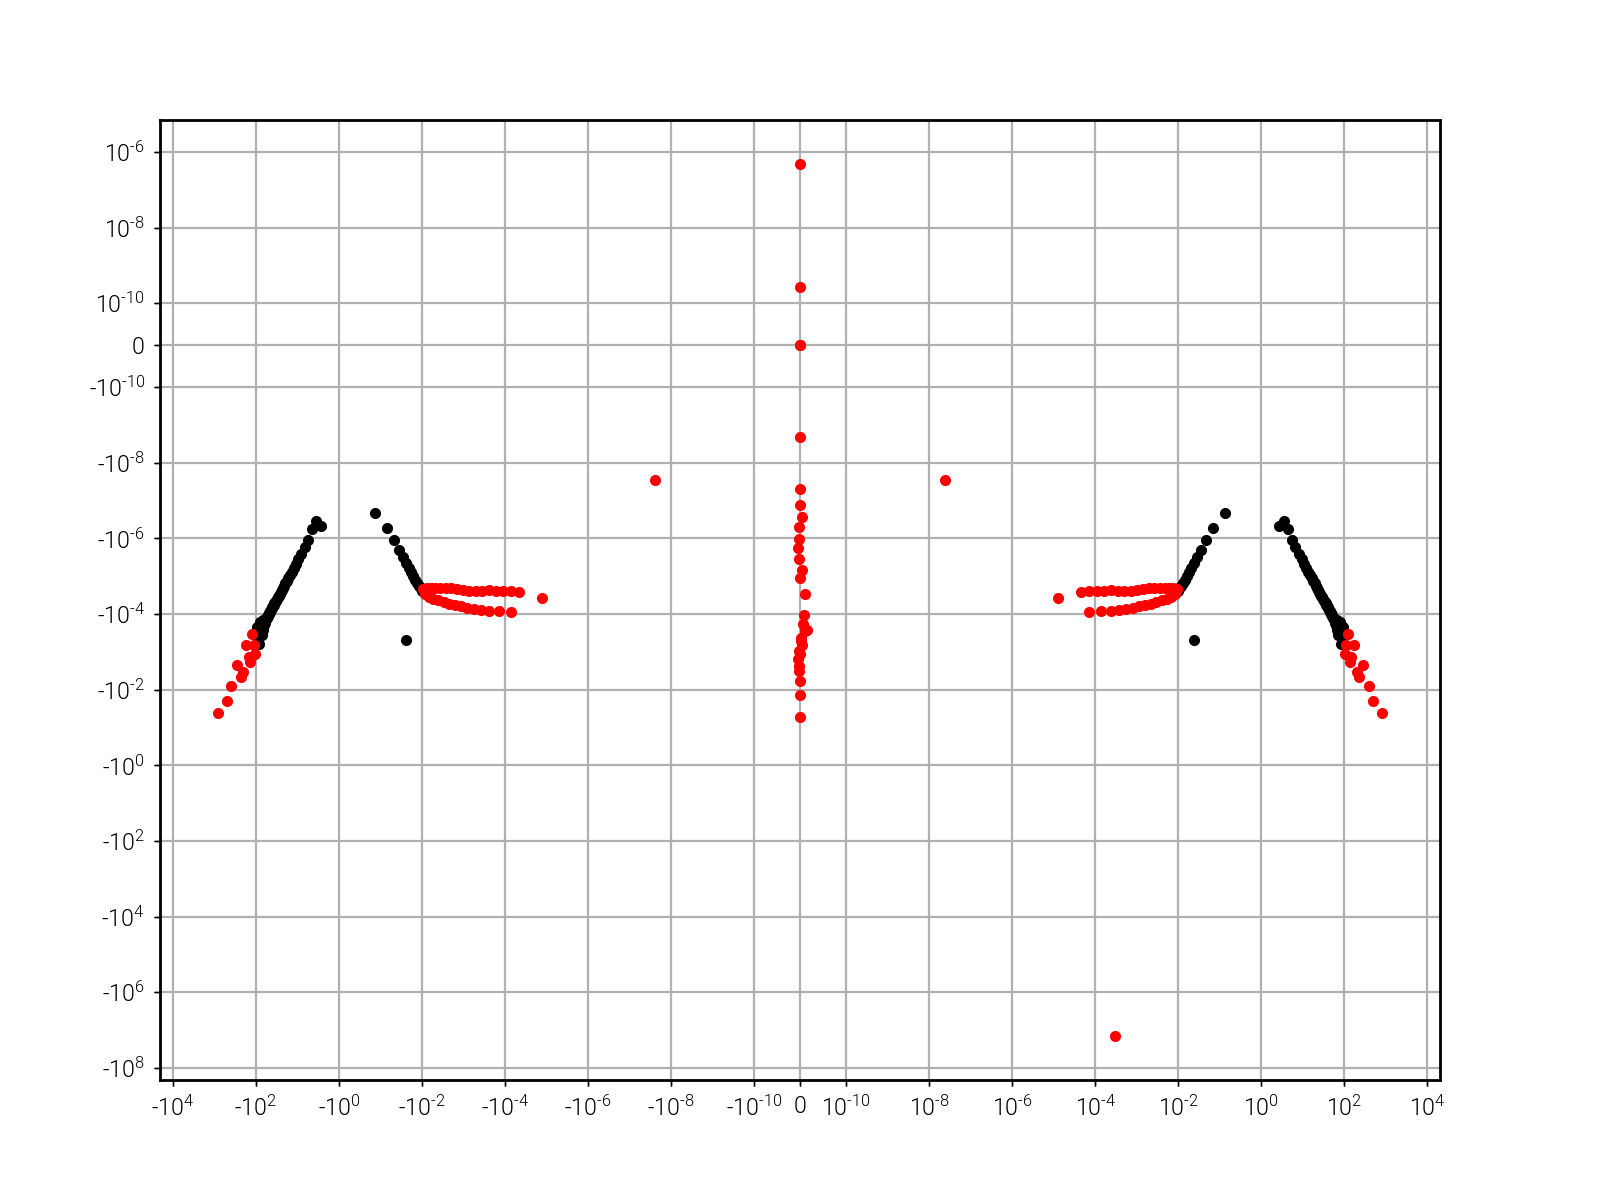

<IPython.core.display.Javascript object>


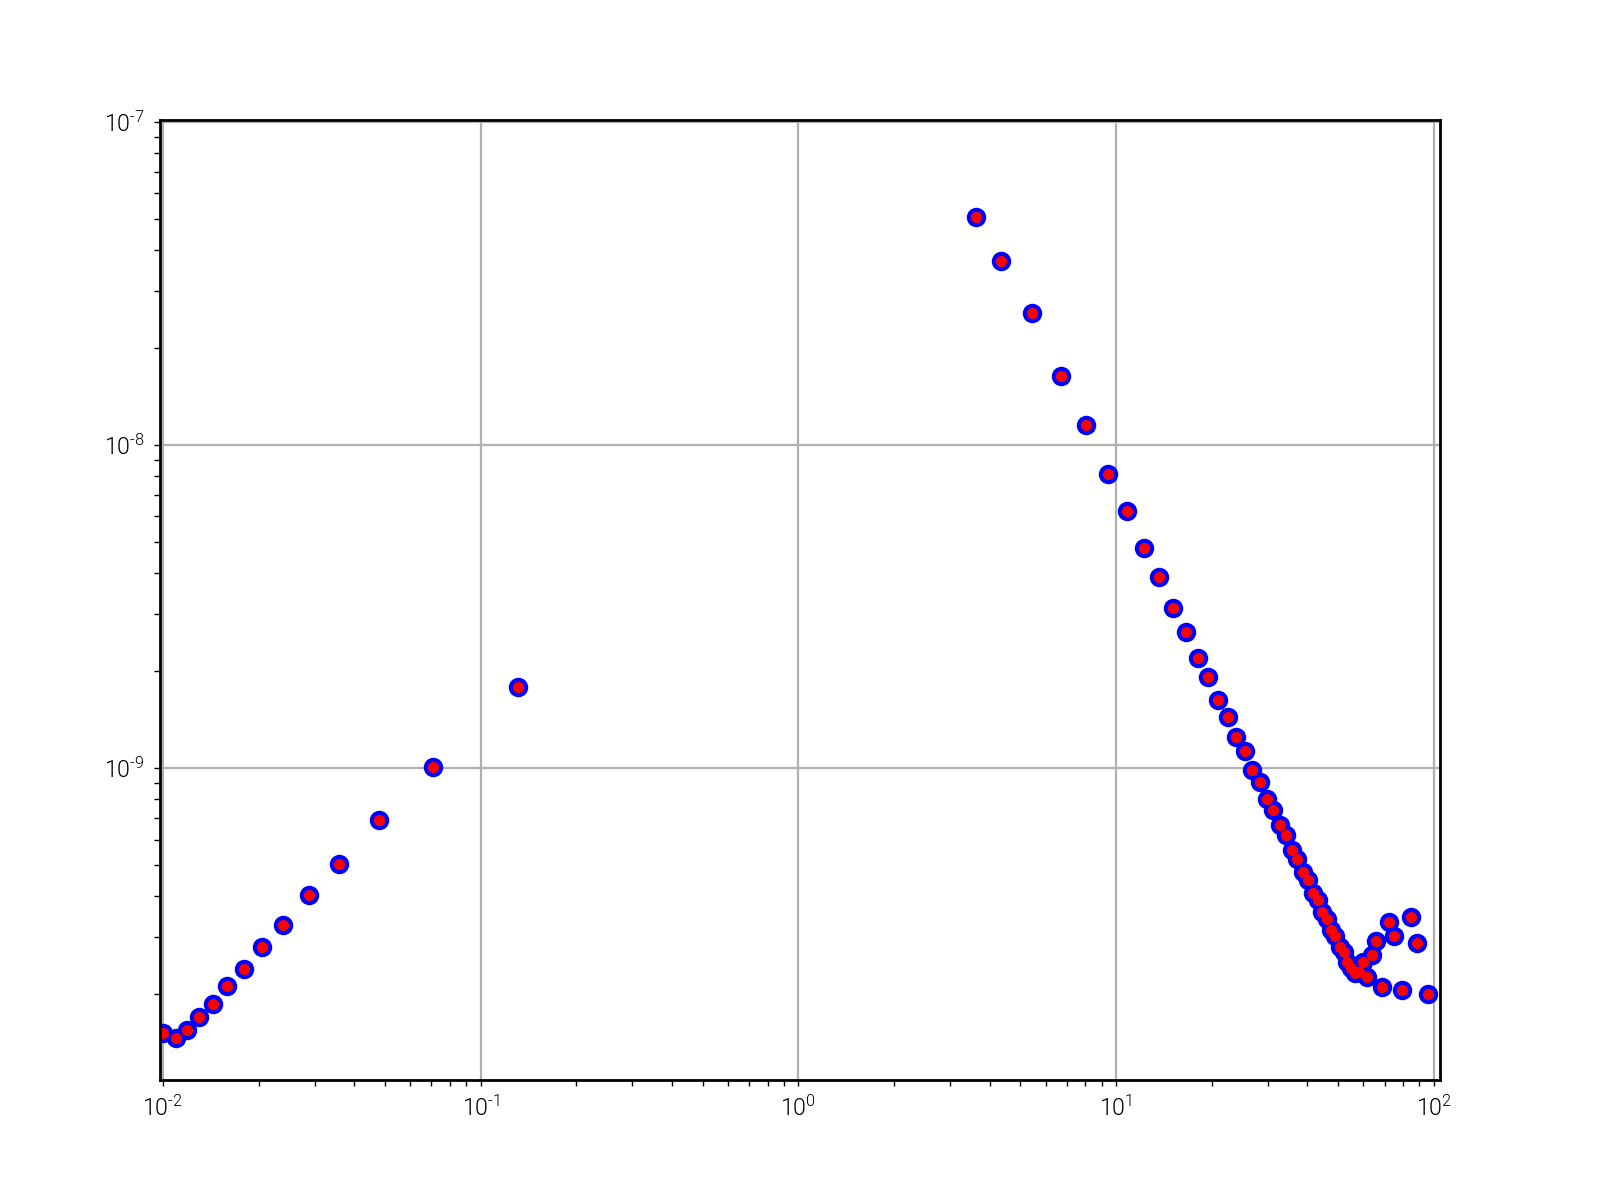

In [20]:
# Construct RHS
p = solver.pencils[0]
pFe = solver.Fe.get_pencil(p)
pFb = solver.Fb.get_pencil(p)
b = p.G_eq * pFe + p.G_bc * pFb
X = solver.state.get_pencil(p).copy()
print('Check L.X = b:', np.allclose(p.L@X, b))

# Bias evals by tidal frequency, which is left out of EVP
freqs = 1j * evals
filt = (np.abs(freqs.real) > 1e-2) * (np.abs(freqs.real) < 1e2)
lam = evals - (-1j*param.ω_tide)
amps_proj = - adj_evecs[:,filt].T.conj() @ b / lam[filt]
X_recon = evecs[:,filt] @ amps_proj
dX = X - X_recon

print('X == X_recon:', np.allclose(X, X_recon))
print('|X - X_recon|/|X|:', (np.dot(dX, dX.conj()) / np.dot(X, X.conj())).real)

plt.figure()
plt.plot(freqs[filt].real, freqs[filt].imag, '.k')
plt.plot(freqs[~filt].real, freqs[~filt].imag, '.r')
plt.xscale('symlog', linthreshx=1e-10)
plt.yscale('symlog', linthreshy=1e-10)
plt.grid()

freq = 1j * evals
plt.figure()
plt.loglog(freqs[filt].real, np.abs(amps_proj), 'ob')
plt.loglog(-freqs[filt].real, np.abs(amps_proj), '.r')
plt.grid()

<IPython.core.display.Javascript object>


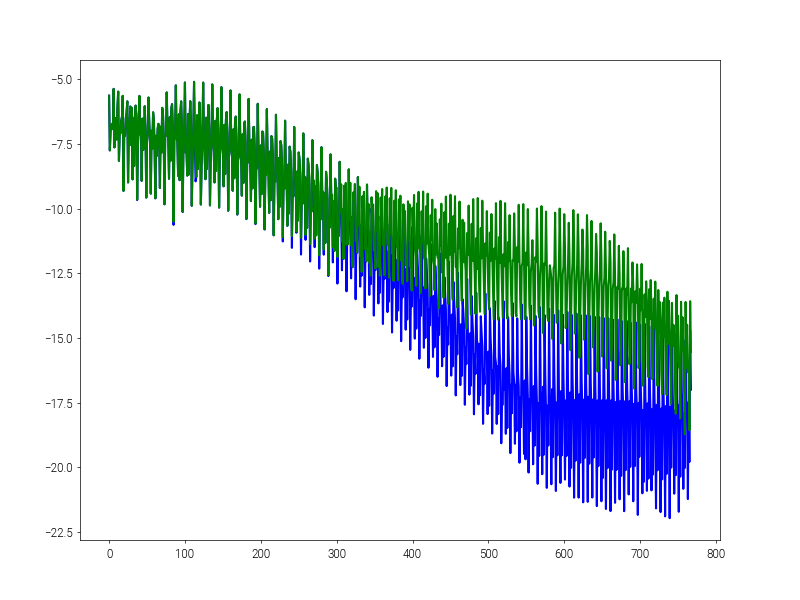

In [87]:
plt.figure()
plt.plot(np.log10(np.abs(X)))
plt.plot(np.log10(np.abs(X_recon)))

<IPython.core.display.Javascript object>


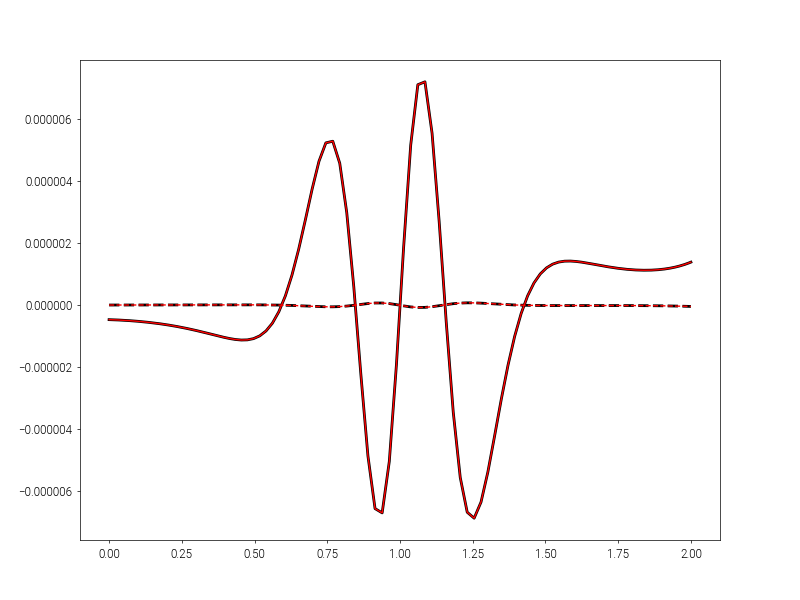

In [86]:
z = domain.grid(0)
f = 'wz'
plt.figure()

solver.state.set_pencil(p, X)
solver.state.scatter()
plt.plot(z, solver.state[f]['g'].real, '-k', lw=2)
plt.plot(z, solver.state[f]['g'].imag, '--k', lw=2)

solver.state.set_pencil(p, X_recon)
solver.state.scatter()
plt.plot(z, solver.state[f]['g'].real, '-r', lw=1)
plt.plot(z, solver.state[f]['g'].imag, '--r', lw=1)

## Examine eigenmodes

<IPython.core.display.Javascript object>


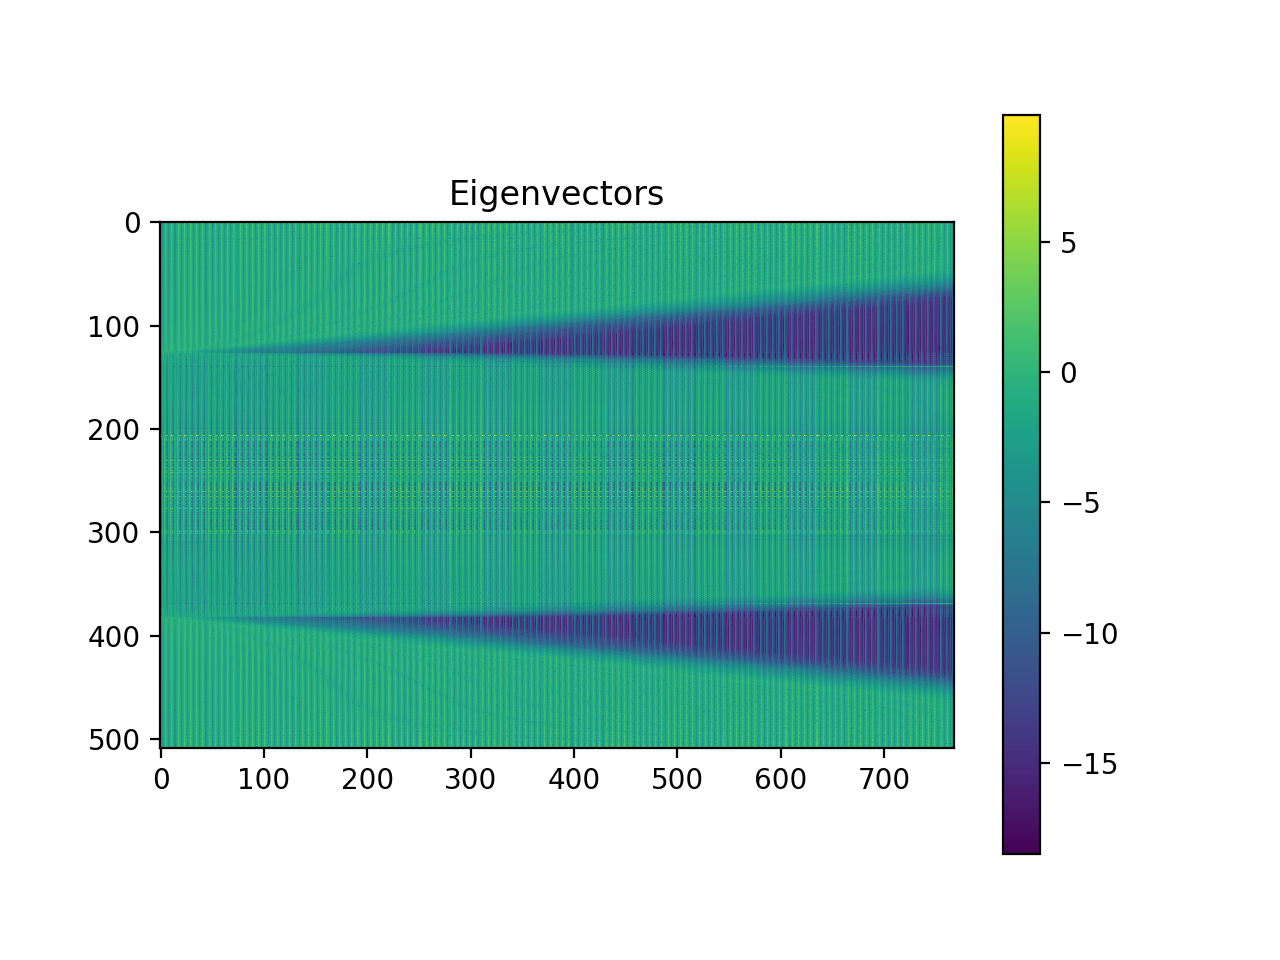

<IPython.core.display.Javascript object>


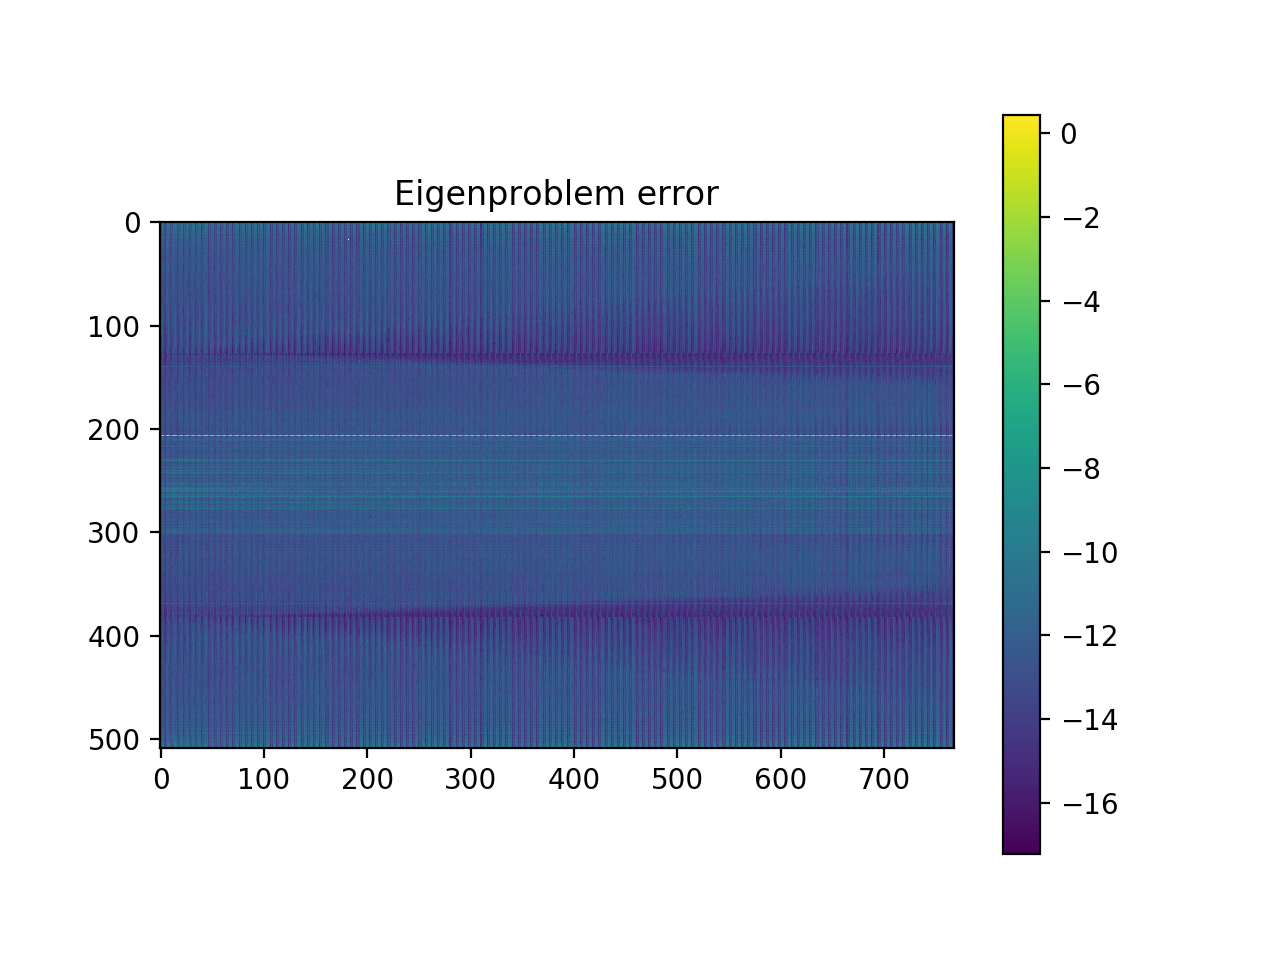

<IPython.core.display.Javascript object>


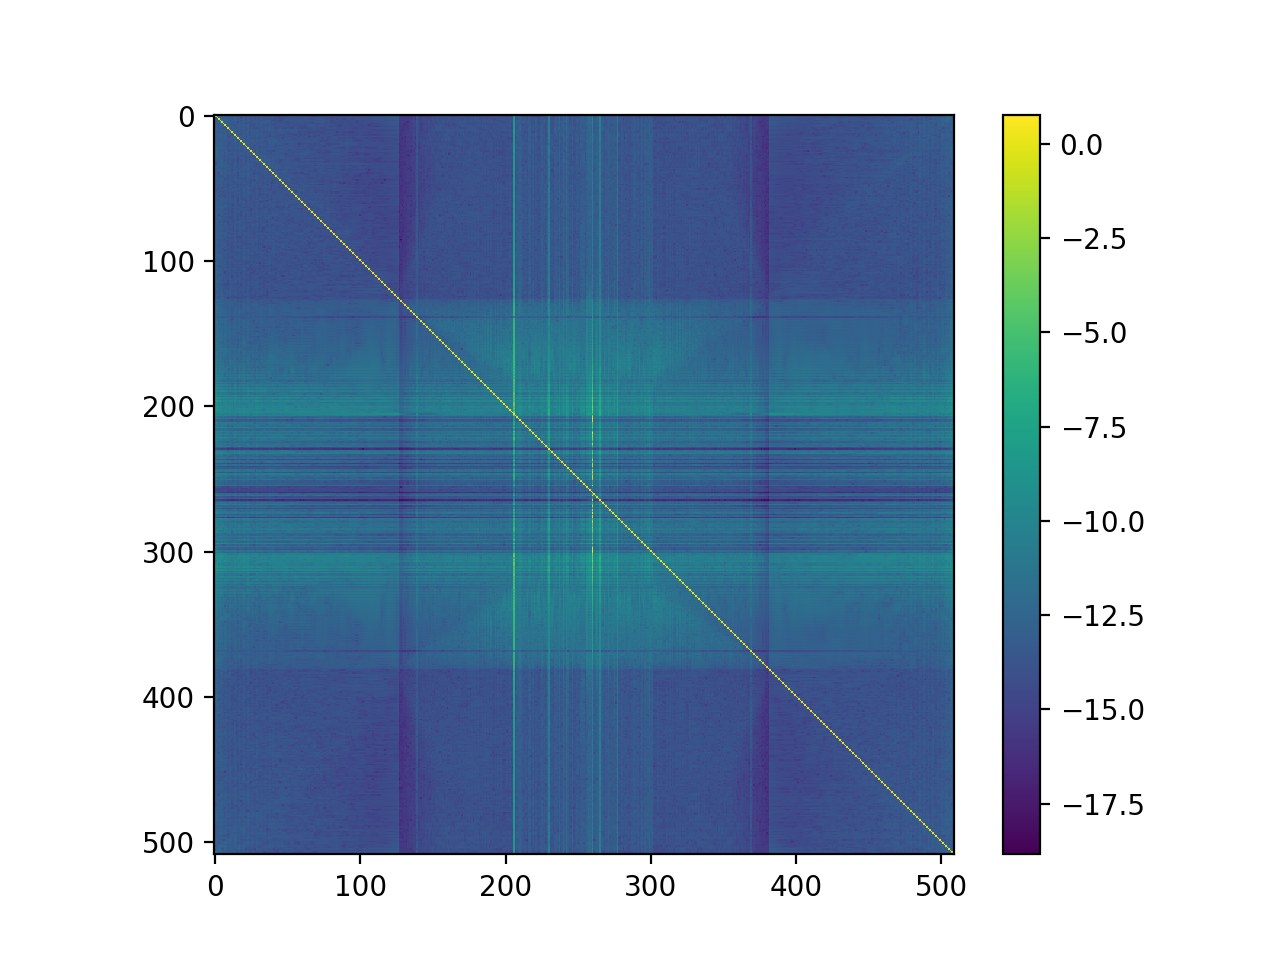

In [17]:
metric = sevp.adjoint_eigenvectors.T.conj() @ pencil.M @ sevp.eigenvectors
gevp_error =  pevp.M @ evecs @ np.diag(evals) + pevp.L @ evecs

plt.figure()
plt.imshow(np.log10(np.abs(evecs.T)), cmap='viridis')
plt.colorbar()
plt.title('Eigenvectors')

plt.figure()
plt.imshow(np.log10(np.abs(gevp_error.T)), cmap='viridis')
plt.colorbar()
plt.title('Eigenproblem error')

plt.figure()
plt.imshow(np.log10(np.abs(metric)), cmap='viridis')
plt.colorbar()

<IPython.core.display.Javascript object>


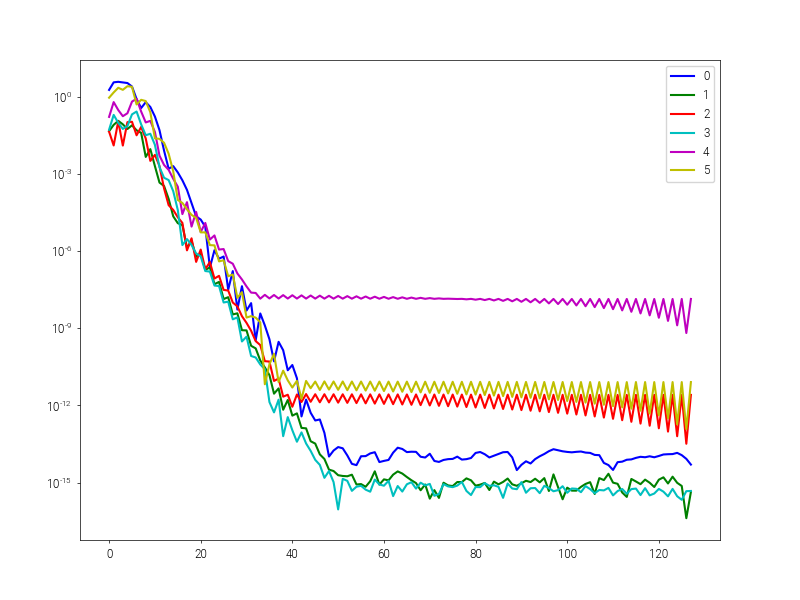

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


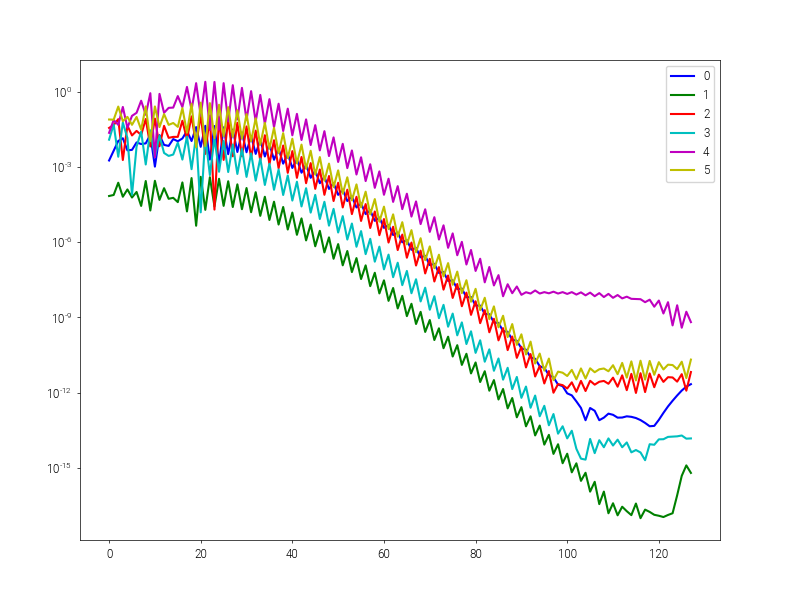

In [26]:
plt.figure()
for i in range(6):
    plt.semilogy(np.abs(evecs[:,filt][:,122][i::6]), label=str(i))
plt.gca().set_color_cycle(None)
for i in range(6):
    pass#plt.semilogy(np.abs(adj_evecs[:,filt][:,122][i::6]), '--', label=str(i))
plt.legend()

plt.figure()
for i in range(6):
    plt.semilogy(np.abs(evecs[:,filt][:,132][i::6]), label=str(i))
plt.gca().set_color_cycle(None)
for i in range(6):
    pass#plt.semilogy(np.abs(adj_evecs[:,filt][:,122][i::6]), '--', label=str(i))
plt.legend()

## 2D linear tide

In [24]:
import importlib
importlib.reload(param)

<module 'parameters' from '/Users/kburns/Hg/pg_coupling/compressible/notebooks/parameters.py'>

In [25]:
domain2, problem2 = tides.linear_tide_2d(param)
solver2 = problem2.build_solver()
solver2.solve()

2018-05-03 23:06:09,020 domain 0/1 DEBUG :: Global coeff shape: [256]
2018-05-03 23:06:09,021 distributor 0/1 DEBUG :: Mesh: []
2018-05-03 23:06:09,025 problems 0/1 DEBUG :: Parsing Eqn 0
2018-05-03 23:06:09,026 problems 0/1 DEBUG ::   Condition: True
2018-05-03 23:06:09,027 problems 0/1 DEBUG ::   LHS string form: dz(pz) + (N2/g)*pz
2018-05-03 23:06:09,028 problems 0/1 DEBUG ::   RHS string form: pz*pz/p/γ
2018-05-03 23:06:09,031 problems 0/1 DEBUG ::   LHS object form: dz(pz) + ((N2*(g**-1))*pz)
2018-05-03 23:06:09,032 problems 0/1 DEBUG ::   RHS object form: ((pz*pz)*(p**-1))*(γ**-1)
2018-05-03 23:06:09,037 problems 0/1 DEBUG ::   L linear form: dz(δpz) + ((N2*(g**-1))*δpz)
2018-05-03 23:06:09,040 problems 0/1 DEBUG ::   dF linear form: ((((pz*pz)*(-1*(p**-2)))*(γ**-1))*δp) + ((((pz*(p**-1))*(γ**-1))*δpz) + (((pz*(p**-1))*(γ**-1))*δpz))
2018-05-03 23:06:09,042 problems 0/1 DEBUG :: Parsing Eqn 1
2018-05-03 23:06:09,043 problems 0/1 DEBUG ::   Condition: True
2018-05-03 23:06:09,044 

2018-05-03 23:06:10,793 problems 0/1 DEBUG ::   LHS string form: wz - dz(w)
2018-05-03 23:06:10,794 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-03 23:06:10,795 problems 0/1 DEBUG ::   LHS object form: wz + (-1*dz(w))
2018-05-03 23:06:10,796 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-03 23:06:10,797 problems 0/1 DEBUG ::   L linear form: wz + (-1*dz(w))
2018-05-03 23:06:10,798 problems 0/1 DEBUG :: Parsing BC 0
2018-05-03 23:06:10,799 problems 0/1 DEBUG ::   Condition: nx != 0
2018-05-03 23:06:10,800 problems 0/1 DEBUG ::   LHS string form: left(txz/μ)
2018-05-03 23:06:10,801 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-03 23:06:10,803 problems 0/1 DEBUG ::   LHS object form: interp((μ*(dx(w) + uz))*(μ**-1),'z',left)
2018-05-03 23:06:10,804 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-03 23:06:10,807 problems 0/1 DEBUG ::   L linear form: interp((μ*(μ**-1))*dx(w),'z',left) + interp((μ*(μ**-1))*uz,'z',left)
2018-05-03 23:06:10,808 problems 0/1 DEBUG :: Parsing 

In [26]:
for p in solver2.pencils[:4]:
    print(p.local_index)
    print(np.linalg.cond(p.L.A))

(0,)
1.0
(1,)
5126950952.688115
(2,)
248148015541.26617
(3,)
3805215039.0226173


<IPython.core.display.Javascript object>


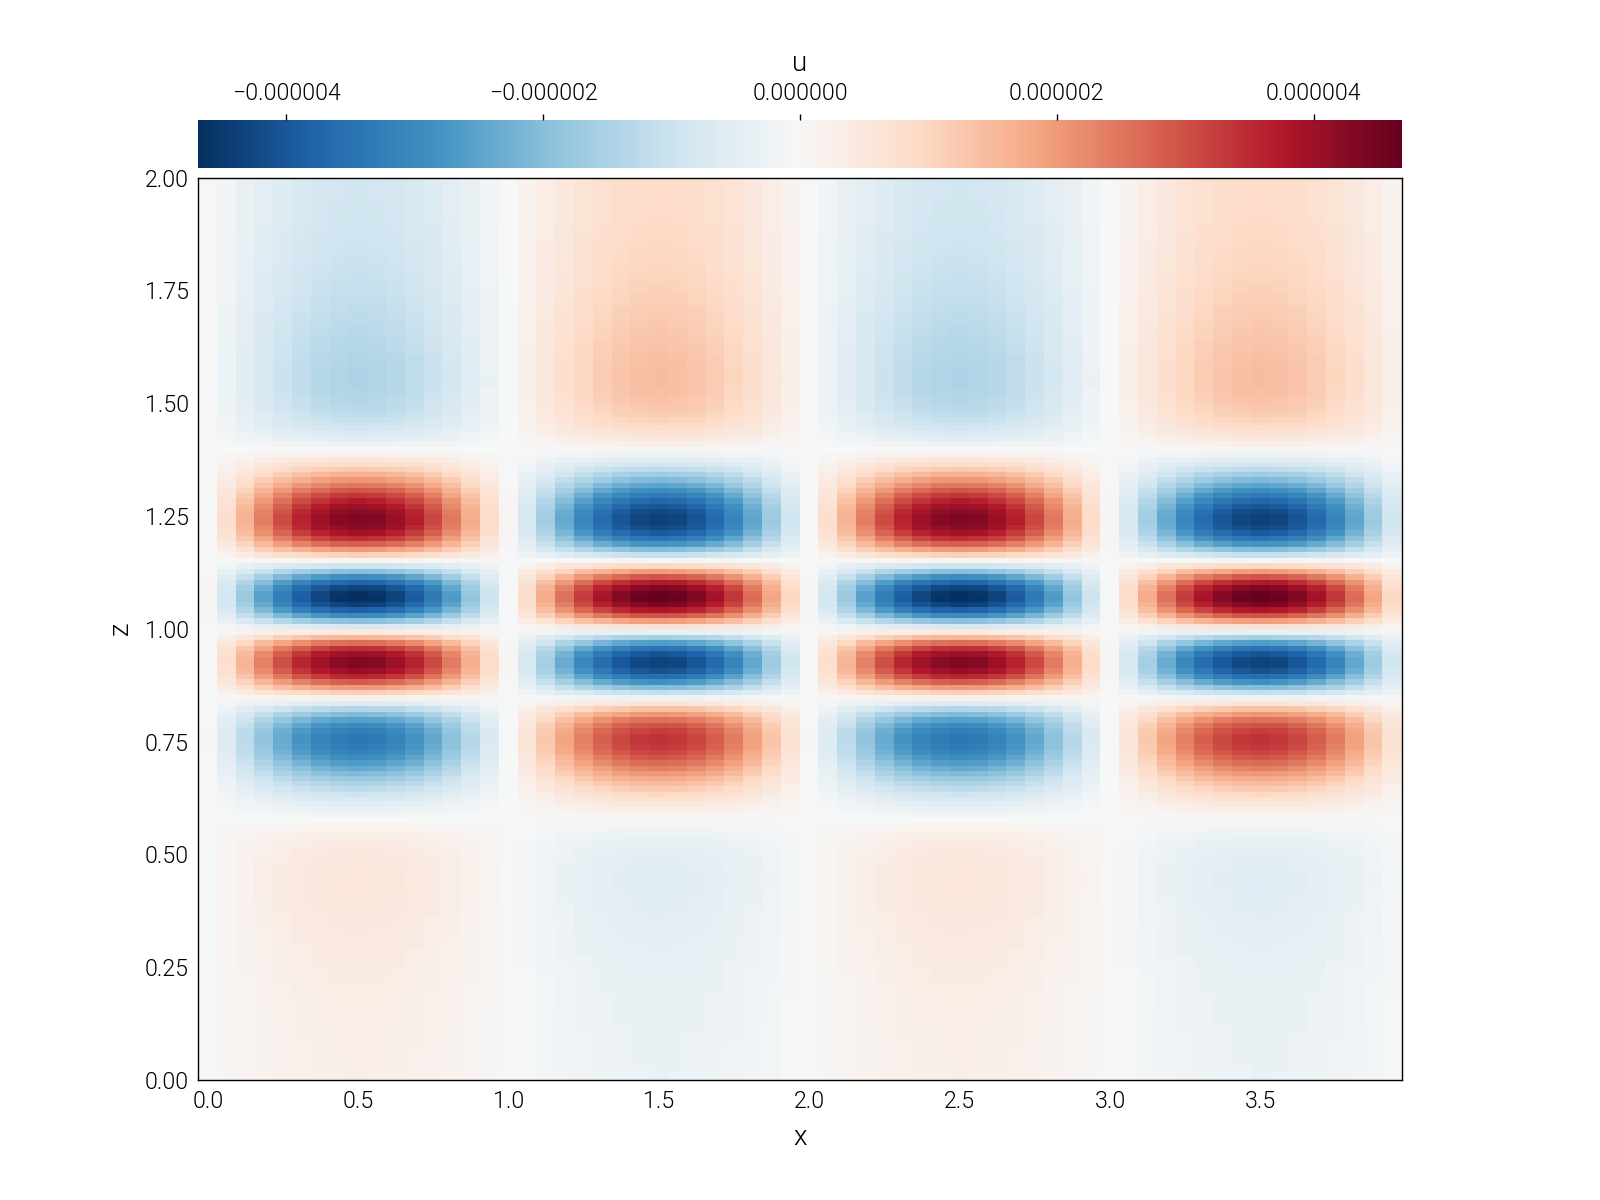

(<matplotlib.axes._axes.Axes at 0x12f6682e8>,
 <matplotlib.axes._axes.Axes at 0x12d819fd0>)

In [27]:
fig, axes = plt.subplots(1, 1)
field = 'u'
f = solver2.state[field]
f.require_grid_space()
plot_tools.plot_bot_2d(f, axes=axes)